In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [25]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- kaggle.house$getCombinedDataset(data$train, data$test) %>% (kaggle.house$na$fixAll)

df.training <- 
    df.combined %>% 
    filter(dataSource == "train") %>% 
    mutate(sale_price_log = log(SalePrice)) %>%
    select(-dataSource, -SalePrice)

trainset.ready <- kaggle.house$trans$doItAll(df.training)

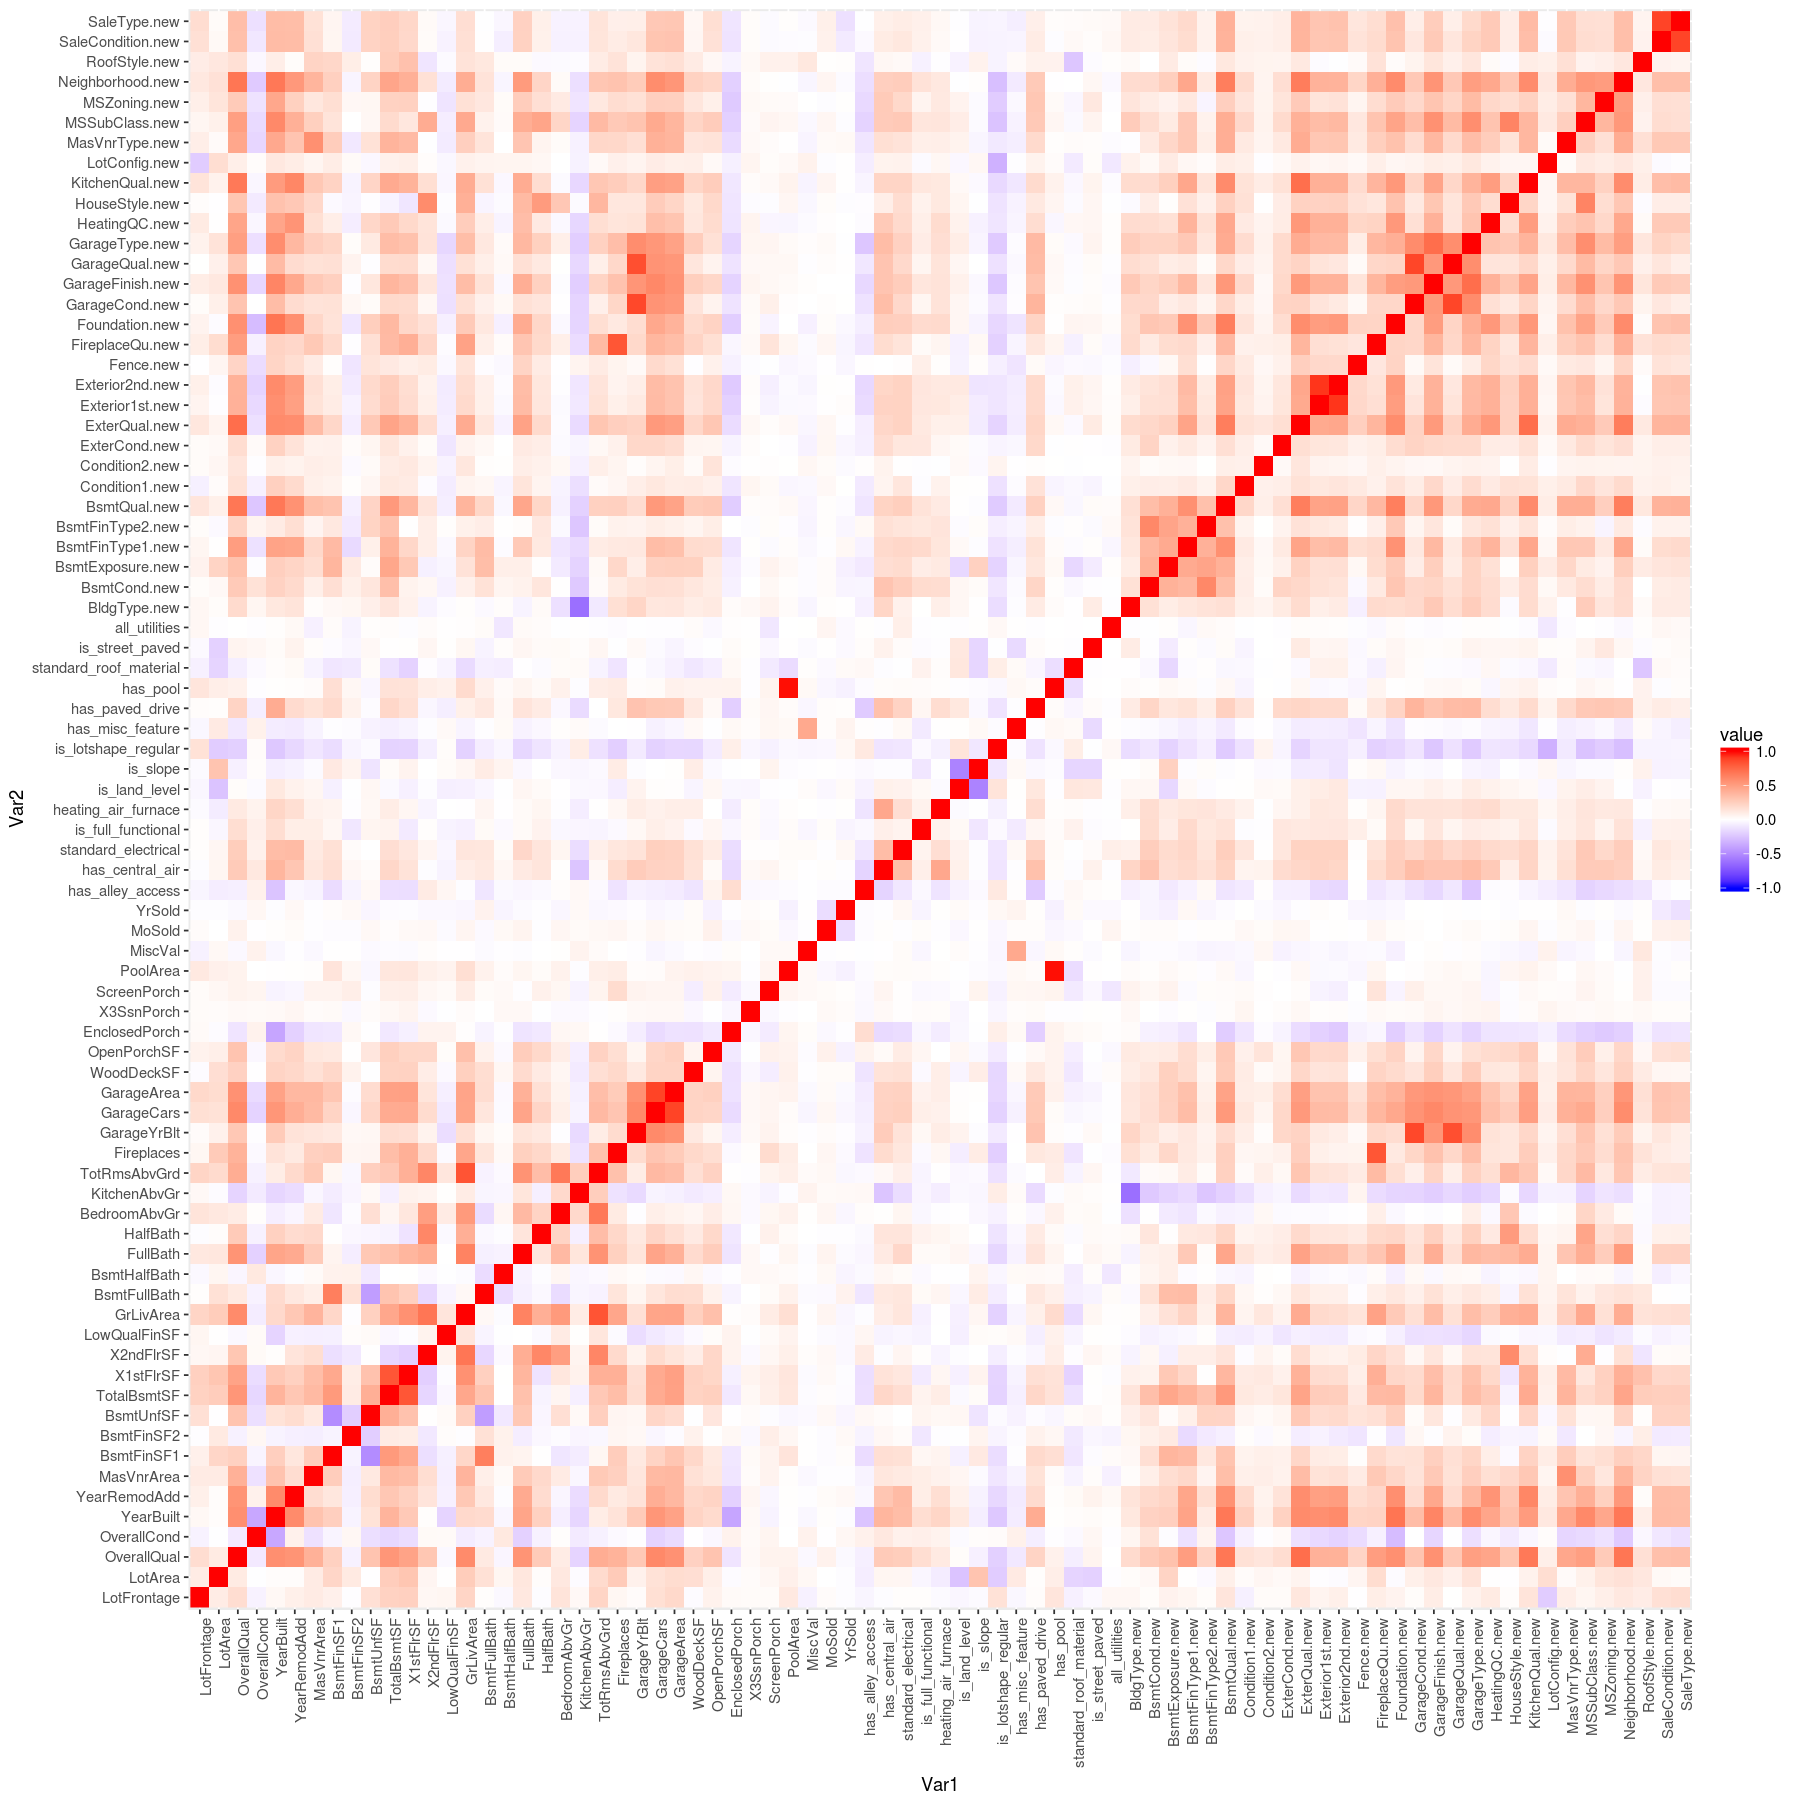

In [29]:
corr.matrix <- cor(trainset.ready %>% select(-SalePrice, -sale_price_log), use="everything")

options(repr.plot.width = 15, repr.plot.height = 15)

reshape2::melt(corr.matrix) %>%
ggplot() + 
geom_raster(aes(x=Var1, y=Var2, fill=value)) +
scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                     midpoint = 0, limit = c(-1,1)) +
theme(axis.text.x = element_text(angle = 90, vjust = 1, 
    size = 9, hjust = 1))

In [62]:
reshape2::melt(corr.matrix) %>% 
    filter(Var1 != Var2, abs(value) > 0.6) %>%
    mutate(pair=ifelse(as.character(Var1) < as.character(Var2), paste0(Var1, Var2), paste0(Var2, Var1))) %>%
    arrange(pair) %>%
    group_by(pair) %>%
    filter(row_number() == 1) %>%
    arrange(desc(value)) %>%
    ungroup %>%
    select(-pair)

Var1,Var2,value
has_pool,PoolArea,0.9896653
Exterior2nd.new,Exterior1st.new,0.9226375
GarageArea,GarageCars,0.8824754
SaleType.new,SaleCondition.new,0.8806649
GarageQual.new,GarageCond.new,0.8753524
GarageCond.new,GarageYrBlt,0.8695332
GarageQual.new,GarageYrBlt,0.8442788
TotRmsAbvGrd,GrLivArea,0.8254894
FireplaceQu.new,Fireplaces,0.8214500
X1stFlrSF,TotalBsmtSF,0.8195300


In [41]:
corr.matrix <- cor(trainset.ready %>% select(OverallQual, Neighborhood.new), 
                   trainset.ready %>% select(-OverallQual, -Neighborhood.new),use="everything")

x <- reshape2::melt(corr.matrix) %>%
    mutate(Var2=as.character(Var2)) %>%
    group_by(Var2) %>%
    summarise(max.abs.corr = max(abs(value))) %>%
    arrange(max.abs.corr) %>%
    rename(name=Var2)


y <- trainset.ready %>% select(-OverallQual, -Neighborhood.new) %>% 
    gather(name, value, -sale_price_log) %>%
    mutate(value.log = log(value + 1)) %>%
    group_by(name) %>% nest %>%
    mutate(
        model =  map(data, ~lm(sale_price_log ~ value, .)),
        glance = map(model, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        model.log =  map(data, ~lm(sale_price_log ~ value.log, .)),
        glance.log = map(model.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        best.r2 = pmax(r2, r2.log)
    ) %>%
    select(name, r2, r2.log, best.r2) %>%
    arrange(desc(best.r2))

x %>% head
y %>% head

name,max.abs.corr
is_land_level,0.01767154
YrSold,0.02734671
all_utilities,0.02755330
X3SsnPorch,0.03037057
BsmtHalfBath,0.04159853
MiscVal,0.04408879


name,r2,r2.log,best.r2
GrLivArea,0.4912982,0.5332704,0.5332704
GarageCars,0.4632501,0.4116007,0.4632501
ExterQual.new,0.4603784,0.4606815,0.4606815
BsmtQual.new,0.4512077,0.4516368,0.4516368
KitchenQual.new,0.4437750,0.4444692,0.4444692
GarageArea,0.4236546,0.2069329,0.4236546


In [44]:
z <- x %>% left_join(y, by='name')

z %>% filter(best.r2 > 0.02)

name,max.abs.corr,r2,r2.log,best.r2
BedroomAbvGr,0.1016764,0.04369926,0.0390713595,0.04369926
LotConfig.new,0.1236159,0.02281380,0.0228135954,0.02281380
BsmtFullBath,0.1453105,0.05580183,0.0570946106,0.05709461
LotArea,0.1562796,0.06621353,0.1599384475,0.15993845
RoofStyle.new,0.1616988,0.04059954,0.0406150449,0.04061504
LotFrontage,0.1765610,0.03214952,0.0005046514,0.03214952
ExterCond.new,0.1793216,0.04481315,0.0448735358,0.04487354
KitchenAbvGr,0.1838822,0.02177044,0.0208161225,0.02177044
BldgType.new,0.1885145,0.03980346,0.0398023468,0.03980346
Condition1.new,0.1897907,0.04087783,0.0408521741,0.04087783
